I'm going to try to predict review sentiment using the IMDB database. I think that a recurrent network is a good approach for this task, as it can handle variable inputs, and also the structure of sentences. It is important for a network to be able to understand negation, something that a bag of words type approach would not be as effective at

In [8]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

num_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

After we have split the dataset into the train and test, lets go ahead and exlpore the data. We don't need to check for nan's because this data structure does not support it, furthermore they have already been preprocessed and it does not contain any. Primarily, I want to see how long the sequences are, check if the data is well distributed and start to plan how I want to break up the data for the LSTM

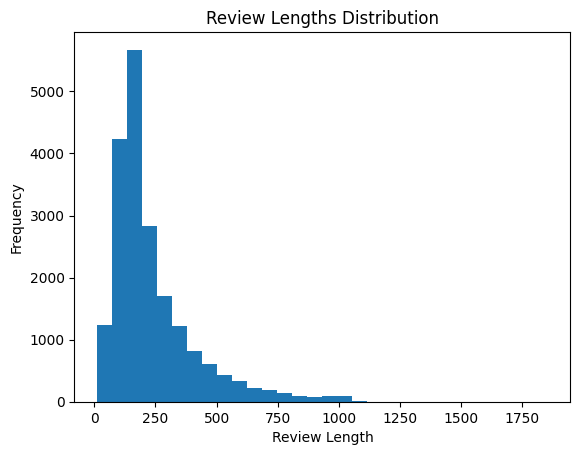

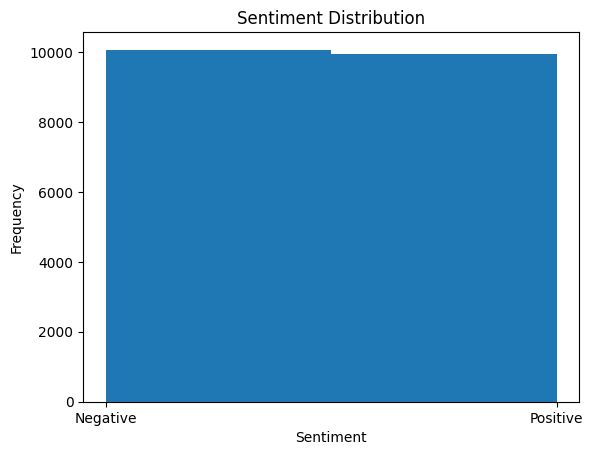

In [ ]:
import matplotlib.pyplot as plt

# Review lengths
review_lengths = [len(x) for x in x_train]

plt.hist(review_lengths, bins=30)
plt.title('Review Lengths Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Sentiment distribution
plt.hist(y_train, bins=2)
plt.title('Sentiment Distribution')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

Given that the sequences are mostly under 500 long, that is probably a good length to pad the reviews to. Furthermore, we see that the data is evenly distributed, which means we can use a simple accuracy metric. This makes sense, because classifying false positives and false negatives are equally important, and a model that guessed randomly would be the same as one that always guesses true or false.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preprocess the data: Padding sequences
maxlen = 500  # Maximum length of reviews
x_train_padded = pad_sequences(x_train, maxlen=maxlen)
x_val_padded = pad_sequences(x_val, maxlen=maxlen)


model = Sequential([
    Embedding(num_words, 32, input_length=maxlen),
    SimpleRNN(100),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_padded, y_train, epochs=10, batch_size=64, validation_data=(x_val_padded, y_val))

#test data
x_test_padded = pad_sequences(x_test, maxlen=maxlen)
test_loss, test_accuracy = model.evaluate(x_test_padded, y_test, verbose=1)


Epoch 1/10
151/313 [=============>................] - ETA: 1:38 - loss: 0.6894 - accuracy: 0.5330

For the RNN model, I am using a 100 unit, single layer RNN. I found that it had the best performance with the tanh function. We can see that this model was fairly sucessful, achieving a validation accuracy of .82

In [11]:
model = Sequential([
    Embedding(num_words, 32, input_length=maxlen),
    LSTM(100, kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_padded, y_train, epochs=10, batch_size=64, validation_data=(x_val_padded, y_val))

x_test_padded = pad_sequences(x_test, maxlen=maxlen)

test_loss, test_accuracy = model.evaluate(x_test_padded, y_test, verbose=1)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/10
313/313 [==============================] - 50s 154ms/step - loss: 1.4667 - accuracy: 0.7168 - val_loss: 1.0016 - val_accuracy: 0.8200
Epoch 2/10
313/313 [==============================] - 28s 91ms/step - loss: 0.7469 - accuracy: 0.8784 - val_loss: 0.6430 - val_accuracy: 0.8662
Epoch 3/10
313/313 [==============================] - 22s 71ms/step - loss: 0.4960 - accuracy: 0.9079 - val_loss: 0.5554 - val_accuracy: 0.8426
Epoch 4/10
313/313 [==============================] - 17s 56ms/step - loss: 0.3707 - accuracy: 0.9181 - val_loss: 0.5757 - val_accuracy: 0.7824
Epoch 5/10
313/313 [==============================] - 12s 38ms/step - loss: 0.2917 - accuracy: 0.9334 - val_loss: 0.4455 - val_accuracy: 0.8684
Epoch 6/10
313/313 [==============================] - 11s 34ms/step - loss: 0.2336 - accuracy: 0.9493 - val_loss: 0.4400 - val_accuracy: 0.8672
Epoch 7/10
313/313 [==============================] - 10s 32ms/step - loss: 0.1950 - accuracy: 0.9592 - val_loss: 0.4608 - val_accuracy

We then moved to an LSTM architecture. I noticed that it was starting to overfit to the training data, so I added regularization to combat this. In the end, it performed much better getting a validation accuracy of .87. However the validation accuracy quickly stopped improving, meaning that we are likely seeing some overfitting towards the end. I would probably implement early stopping in the future.

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, GRU, Dense

model = Sequential([
    Embedding(num_words, 32, input_length=maxlen),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_padded, y_train, epochs=10, batch_size=64, validation_data=(x_val_padded, y_val))


Epoch 1/10
313/313 [==============================] - 34s 103ms/step - loss: 0.4483 - accuracy: 0.7800 - val_loss: 0.3350 - val_accuracy: 0.8588
Epoch 2/10
313/313 [==============================] - 22s 69ms/step - loss: 0.2641 - accuracy: 0.8982 - val_loss: 0.3131 - val_accuracy: 0.8736
Epoch 3/10
313/313 [==============================] - 14s 43ms/step - loss: 0.2152 - accuracy: 0.9187 - val_loss: 0.3453 - val_accuracy: 0.8716
Epoch 4/10
313/313 [==============================] - 13s 41ms/step - loss: 0.1774 - accuracy: 0.9355 - val_loss: 0.3402 - val_accuracy: 0.8754
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 0.1359 - accuracy: 0.9531 - val_loss: 0.4480 - val_accuracy: 0.8738
Epoch 6/10
313/313 [==============================] - 9s 30ms/step - loss: 0.0957 - accuracy: 0.9675 - val_loss: 0.4481 - val_accuracy: 0.8640
Epoch 7/10
313/313 [==============================] - 9s 30ms/step - loss: 0.0761 - accuracy: 0.9746 - val_loss: 0.5400 - val_accuracy: 

And finally with the GRU, we also saw a similary accuracy improvement. It managed to attain a validation accuracy of .87. I think the performance gap between the simple RNN and the more complex versions is their ability to learn long term dependencies. Reviews inherently contain long term data, such as a reviewer giving their first thougths, and then getting into the details later in the review. It is most important to remember what they were saying at the beginning of the review.

In [ ]:
!pip install gensim

In [26]:
import numpy as np
from gensim.models import KeyedVectors

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

def dissimilarity(vec1, vec2):
    mse = np.mean((vec1 - vec2) ** 2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return mse / (norm_vec1 * norm_vec2)


import gensim.downloader as api

model = api.load("glove-twitter-25")


words = ['king', 'queen', 'man', 'woman', 'apple', 'orange', 'zombie', 'skeleton']

# Calculate cosine similarities and dissimilarities for each pair
results = []
for i in range(len(words)):
    for j in range(i + 1, len(words)):
        vec1 = model[words[i]]
        vec2 = model[words[j]]
        cos_sim = cosine_similarity(vec1, vec2)
        dis_sim = dissimilarity(vec1, vec2)
        results.append((cos_sim, dis_sim))


cosine_similarities = [result[0] for result in results]
dissimilarities = [result[1] for result in results]

correlation_coefficient = np.corrcoef(cosine_similarities, dissimilarities)[0, 1]

print(f"Correlation Coef: {correlation_coefficient}")

Correlation Coef: -0.9847736648997599


For my dissimilarity score, I chose to take the MSE between each component of the vector, and then normalize it by dividing it my the magnitude of the original vectors. I decided to test how well it works by choosing a group of words, and then comparing both metrics with each other for all combinations of the words. As you can see from the correlation coeficient, this is a very good measure of dissimilarity.